<table align="center">
  <td align="center"><a target="_blank" href="http://introtodeeplearning.com">
        <img src="http://introtodeeplearning.com/images/colab/mit.png" style="padding-bottom:5px;" />
      Visit MIT Deep Learning</a></td>
  <td align="center"><a target="_blank" href="https://colab.research.google.com/drive/1-nUvyglfv8iap-JRGmyZBQUdIDr-cq3j">
        <img src="http://introtodeeplearning.com/images/colab/colab.png?v2.0"  style="padding-bottom:5px;" />Run in Google Colab</a></td>
  <td align="center"><a target="_blank" href="https://github.com/nem0-97/MusicGenRNN">
        <img src="http://introtodeeplearning.com/images/colab/github.png"  height="70px" style="padding-bottom:5px;"  />View Source on GitHub</a></td>
</table>


# Lab 1: Intro to TensorFlow and Music Generation with RNNs

# Part 2: Music Generation with RNNs

In this portion of the lab, we will explore building a Recurrent Neural Network (RNN) for music generation. We will train a model to learn the patterns in raw sheet music in [ABC notation](https://en.wikipedia.org/wiki/ABC_notation) and then use this model to generate new music. 

## 2.1 Dependencies 
First, let's download the course repository, install dependencies, and import the relevant packages we'll need for this lab.

In [0]:
! git clone https://github.com/aamini/introtodeeplearning_labs.git
% cd introtodeeplearning_labs
! git pull
% cd ..
! git clone https://github.com/nem0-97/MusicGenRNN.git
! mv MusicGenRNN/musicGenRNN.h5 ./

Cloning into 'introtodeeplearning_labs'...
remote: Enumerating objects: 1072, done.
remote: Total 1072 (delta 0), reused 0 (delta 0), pack-reused 1072
Receiving objects: 100% (1072/1072), 121.28 MiB | 32.75 MiB/s, done.
Resolving deltas: 100% (597/597), done.
/content/introtodeeplearning_labs
Already up to date.
/content
Cloning into 'MusicGenRNN'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 0), reused 4 (delta 0), pack-reused 0
Unpacking objects: 100% (4/4), done.


In [0]:
import tensorflow as tf 
tf.enable_eager_execution()

import numpy as np
import os
import time
import functools

import introtodeeplearning_labs as util

is_correct_tf_version = '1.13.0' in tf.__version__
#assert is_correct_tf_version, "Wrong tensorflow version ({}) installed".format(tf.__version__)

is_eager_enabled = tf.executing_eagerly()
assert is_eager_enabled,      "Tensorflow eager mode is not enabled"

'''If this does not return true on Colaboratory, 
    go to runtime -> change runtime type -> GPU
    or see a TA'''
assert tf.test.is_gpu_available()

!apt-get install abcmidi timidity > /dev/null 2>&1

## 2.2 Dataset

![Let's Dance!](http://33.media.tumblr.com/3d223954ad0a77f4e98a7b87136aa395/tumblr_nlct5lFVbF1qhu7oio1_500.gif)

We've gathered a dataset of thousands of Irish folk songs, represented in the ABC notation. Let's download the dataset: 

In [0]:
path_to_file = tf.keras.utils.get_file('irish.abc', 'https://raw.githubusercontent.com/aamini/introtodeeplearning_labs/2019/lab1/data/irish.abc')

212992/197618 [================================] - 0s 0us/step


### Inspect the dataset

We can take a look and listen to get a better sense of the dataset:

In [0]:
text = open(path_to_file).read()
# length of text is the number of characters in it
print ('Length of text: {} characters'.format(len(text)))

Length of text: 197618 characters


We can grab a song from our dataset as an example and play it back: 

In [0]:
util.play_generated_song(text)

In [0]:
# Take a look at the first 250 characters in text
print(text[:250])

X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:


One important thing to think about is that this notation of music does not simply contain information on the notes being played, but additionally there is meta information such as the song title, key, and tempo. How does the number of different characters are present in the text file impact the complexity of the learning problem? This will become important soon, when we generate a numerical representation for the text data.

In [0]:
# The unique characters in the file
vocab = sorted(set(text))
print ('{} unique characters'.format(len(vocab)))

83 unique characters


<!-- TODO: here explanation of the one-hot encoding, getting the unique characters in the file -->

## 2.3 Process the dataset for the learning task

Let's take a step back and consider our prediction task. We're trying to train a RNN model to learn patterns in ABC music, and then use this model to generate (i.e., predict) a new piece of music based on this learned information. 

Breaking this down, what we're really asking the model is: given a character, or a sequence of characters, what is the most probable next character? We'll train the model to perform this task. 

To achieve this, we will input a sequence of characters to the model, and train the model to predict the output, that is, the following character at each time step. RNNs maintain an internal state that depends on previously seen elements, so information about all characters seen up until a given moment will be taken into account in generating the prediction.

### Vectorize the text

Before we begin training our RNN model, we'll need to create a numerical representation of our text-based dataset. To do this, we'll generate two lookup tables: one that maps characters to numbers, and a second that maps numbers back to characters. Recall that we just identified the unique characters present in the text.

In [0]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
text_as_int = np.array([char2idx[c] for c in text])

# Create a mapping from indices to characters
idx2char = np.array(vocab)

This gives us an integer representation for each character. Observe that the unique characters (i.e., our vocabulary) in the text are mapped as indices from 0 to `len(unique)`. Let's take a peek at this numerical representation of our dataset:

In [0]:
def generate_text(model, start_string, generation_length=1000):
  # Evaluation step (generating ABC text using the learned RNN model)

  '''TODO: convert the start string to numbers (vectorize)'''
  input_eval =  np.array([char2idx[c] for c in start_string])
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Here batch size == 1
  model.reset_states()
  bar = util.create_progress_bar()
  for i in bar(range(generation_length)):
      '''TODO: evaluate the inputs and generate the next character predictions'''
      predictions = model(input_eval)
      
      # Remove the batch dimension
      predictions = tf.squeeze(predictions, 0)
      
      '''TODO: use a multinomial distribution to sample'''
      predicted_id = tf.multinomial(predictions, num_samples=1)[-1,0].numpy() # TODO 
      
      # Pass the prediction along with the previous hidden state
          # as the next inputs to the model
      input_eval = tf.expand_dims([predicted_id], 0)
      
      '''TODO: add the predicted character to the string of generated text!'''
      '''Hint: consider what format the prediction is in, vs. the output'''
      text_generated.append(idx2char[predicted_id]) # TODO 

  return (start_string + ''.join(text_generated))

In [0]:
#This is what the model in already provided does, continue on to create and train your own
model=tf.keras.models.load_model('musicGenRNN.h5')

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
# note that a valid song is not always generated, and sometimes multiple ones are
text = generate_text(model,"X")
util.play_generated_song(text)

In [0]:
print(text)

X:98
K:D Major
cA|B2D AGG|GBA Ade|fec B2d|BcA ecB|!
GBB A2F|AAA EFG|AAc BAA|BAG e2:|!
A|f2a fg|be g2f gfe|gfa eff|!
d2B deg|fdf dBd ed:|!
e3|gFA2 AGE2|EEF2 fdef|egef fgaa|fggb g3d:|!
B2dBc d2ge|e2ad f=gge|dcec dfde|Bcd2 B2de|f3c ABcA|G3c A2A|]!
g|a2ef fde|AdA BcA|D2cA AG2|GEE EFE2|Acd2 edBG|aef g2:|!
G1|A2 gfge|fgge dBde|cBec deag2 edBc|!
F3FA cedc|g2de dAc2|F2Bc Acedd|ABAG B2ag|fdc2 fded|!
D2f B2d|efd c3E|A2G2 AGAF|AcBA A3f|agf adA|AGB e2f|!
ffd BdB|AGA F2f|fgF A2G|ABA AGB AGAG|B3d gfe|fc AFD E2:|!
def fed|cdd ded|BdA Bcg|fdd gfgg|efde BdcA|dcAF EFD|!
d2GA A3ragagafgrefe2 d2AF|G2G2 ggfd|A2ef edBc|fdaf eced|gBcd e2af|d2D2:|!

X:3l:7
T:kvaniek
Z: id:dc-reel-56
M:6/8
L:1/8
K:A iagr
GGG A,AE|,AEA G2D|AFA2 ABd|B2A/AB BAG|EED AF|dfe dBB|A2A E2:|!
edB dBAd|e^dB dfaf|g2 AFA A2F,E|A2e2 aggd|dfeb gfde|!
aagf geef|g2ag e2cA|AFF2 G2cA|AAFA D2:|!
d:|!

X:129
T:Girid Lian Fuful th iabd gaun
Z: id:dc-eal-53
M
L:1/8
L:1/8
K:D DFE|DEDA, EDED|F2G2 A2ef|fed2 cDEF|d2dB cAde|ecAG dfec|]!
d3d edee|fddc ABE

In [0]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  '!' :   2,
  ' ' :   1,
  '#' :   4,
  '"' :   3,
  "'" :   5,
  ')' :   7,
  '(' :   6,
  '-' :   9,
  ',' :   8,
  '/' :  11,
  '.' :  10,
  '1' :  13,
  '0' :  12,
  '3' :  15,
  '2' :  14,
  '5' :  17,
  '4' :  16,
  '7' :  19,
  '6' :  18,
  ...
}


We can also look at how the first part of the text is mapped to an integer representation:

In [0]:
print ('{} ---- characters mapped to int ---- > {}'.format(repr(text[:13]), text_as_int[:13]))

'X:98\nK:D Majo' ---- characters mapped to int ---- > [49 22 13  0 45 22 26 67 60 79 56 69 59]


### Create training examples and targets

Our next step is to actually divide the text into example sequences that we'll use during training. Each input sequence that we feed into our RNN will contain `seq_length` characters from the text. We'll also need to define a target sequence for each input sequence, which will be used in training the RNN to predict the next character. For each input, the corresponding target will contain the same length of text, except shifted one character to the right.

To do this, we'll break the text into chunks of `seq_length+1`. Suppose `seq_length` is 4 and our text is "Hello". Then, our input sequence is "Hell", and the target sequence "ello".

First, use the `tf.data.Dataset.from_tensor_slices` function to convert the text vector into a stream of character indices. This is a function within `tf.data` which is generally useful for importing data.

The batch method will then let us convert this stream of character indices to sequences of the desired size.

In [0]:
# The maximum length sentence we want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//seq_length

# Create training examples / targets
# Note how we are using the `tf.data` module!
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

'''TODO: use the batch function to generate sequences of the desired size.'''
'''Hint: youll want to set drop_remainder=True'''
sequences = char_dataset.batch(seq_length+1,drop_remainder=True)


Next, we need to define the input and target texts for each sequence. 

Define a function to do this, and then use the [`map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) method to apply a simple function to each batch. 

In [0]:
'''TODO: define a function that takes a sequence (chunk) and outputs both the input text and target text sequences'''
'''Hint: consider the "Hello" example'''
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

'''TODO: use the map method to apply your function to the list of sequences to generate the dataset!'''
dataset = sequences.map(split_input_target)

For each of these vectors, each index is processed at a single time step. So, for the input at time step 0, the model receives the index for the first character in the sequence, and tries to predict the index of the next character. At the next timestep, it does the same thing, but the `RNN` considers the information from the previous step, i.e., its updated state, in addition to the current input.

We can make this concrete by taking a look at how this works over the first several characters in our text:

In [0]:
for input_example, target_example in dataset.take(1):
  
  for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
      print("Step {:4d}".format(i))
      print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
      print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step    0
  input: 49 ('X')
  expected output: 22 (':')
Step    1
  input: 22 (':')
  expected output: 13 ('1')
Step    2
  input: 13 ('1')
  expected output: 0 ('\n')
Step    3
  input: 0 ('\n')
  expected output: 45 ('T')
Step    4
  input: 45 ('T')
  expected output: 22 (':')


### Create training batches

Great! Now we have our text split into sequences of manageable size. But before we actually feed this data into our model, we'll [`shuffle`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) the data (for the purpose of stochastic gradient descent) and then pack it into batches which will be used during training.

In [0]:
# Batch size 
BATCH_SIZE = 64
steps_per_epoch = examples_per_epoch//BATCH_SIZE

# Buffer size is similar to a queue size
# This defines a manageable data size to put into memory, where elements are shuffled
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

# Examine the dimensions of the dataset
dataset

<DatasetV1Adapter shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

## 2.4 The Recurrent Neural Network (RNN) model

Now we're ready to define and train a RNN model on our ABC music dataset, and then use that trained model to generate a new song. We'll train our RNN using batches of song snippets from our dataset, which we generated in the previous section.

The model is based off the LSTM architecture, where we use a state vector to maintain information about the temporal relationships between consecutive characters. The final output of the LSTM is then fed into a fully connected [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) layer where we'll output a softmax over each character in the vocabulary, and then sample from this distribution to predict the next character. 

As we introduced in the first portion of this lab, we'll be using the Keras API, specifically, [`tf.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential), to define the model. Three layers are used to define the model:

* [`tf.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding): This is the input layer, consisting of a trainable lookup table that maps the numbers of each character to a vector with `embedding_dim` dimensions.
* [`tf.keras.layers.LSTM`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM): Our LSTM network, with size `units=rnn_units`. 
* [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): The output layer, with `vocab_size` outputs.


<img src="https://raw.githubusercontent.com/aamini/introtodeeplearning_labs/2019/lab1/img/lstm_unrolled-01-01.png" alt="Drawing"/>

### Define the RNN model

Let's define some important dimensions:

In [0]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension 
embedding_dim = 256

# The number of RNN units
'''TODO: after running through the lab, try changing the number of units in the network to see how it affects performance'''
rnn_units = 1024

Now, we can define the function that will be used to actually build the model. 

If you'll be running your models on a GPU, you will want to use the [`CuDNNLSTM`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/CuDNNLSTM) function:

In [0]:
if tf.test.is_gpu_available():
  LSTM = tf.keras.layers.CuDNNLSTM
else:
  LSTM = functools.partial(
    tf.keras.layers.LSTM, recurrent_activation='sigmoid')

LSTM = functools.partial(LSTM, 
  return_sequences=True, 
  recurrent_initializer='glorot_uniform',
  stateful=True
)

The time has come! Fill in the `TODOs` to define the RNN model within the `build_model` function, and then call the function you just defined to instantiate the model!

In [0]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, 
                              batch_input_shape=[batch_size, None]),
    LSTM(rnn_units), # TODO: Define the dimensionality of the RNN
    tf.keras.layers.Dense(vocab_size) # TODO: Define the dimensionality of the Dense layer
  ])

  return model

In [0]:
'''TODO: call the build_model function to instantiate the RNN model'''
model = build_model(vocab_size,embedding_dim,rnn_units,BATCH_SIZE)


### Test out the RNN model

It's always a good idea to run a few simple checks on our model to see that it behaves as expected.  

First, we can use the `Model.summary` function to print out a summary of our model's internal workings. Here we can check the layers in the model, the shape of the output of each of the layers, the batch size, etc.

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           21248     
_________________________________________________________________
cu_dnnlstm (CuDNNLSTM)       (64, None, 1024)          5251072   
_________________________________________________________________
dense (Dense)                (64, None, 83)            85075     
Total params: 5,357,395
Trainable params: 5,357,395
Non-trainable params: 0
_________________________________________________________________


We can also quickly check the dimensionality of our output, using a sequence length of 100. Note that the model can be run on inputs of any length.

In [0]:
for input_example_batch, target_example_batch in dataset.take(1): 
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(TensorShape([Dimension(64), Dimension(100), Dimension(83)]), '# (batch_size, sequence_length, vocab_size)')


### Predictions from the untrained model

Let's take a look at what our untrained model is predicting.

To get actual predictions from the model, we sample from the output distribution, which is defined by a softmax over our character vocabulary. This will give us actual character indices.

Note here that we sample from this probability distribution, as opposed to simply taking the argmax, which can cause the model to get stuck in a loop.

Let's try this sampling out for the first example in the batch.

In [0]:
sampled_indices = tf.random.multinomial(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

Note how we used a [multinomial distribution](http://onlinestatbook.com/lms/probability/multinomial.html) to sample over the example prediction. This gives a prediction of the next character (specifically its index) at each timestep:

In [0]:
sampled_indices

array([67,  5, 46, 67, 42, 29, 40, 18, 74, 59, 43, 74,  9, 21, 51, 26, 71,
       56, 13, 35, 40, 65,  3, 41,  5,  4, 65, 67,  3, 42, 30, 77, 72, 45,
       13, 70, 76, 56,  7, 64, 13, 15,  6, 40, 47, 66, 75, 74, 12, 57,  5,
       30, 34,  0, 45, 55, 25, 59, 59, 50,  7, 74, 11, 12, 32,  8, 35, 67,
       13, 67, 28, 37, 11, 22, 48, 37, 61, 17, 51, 79, 41,  8, 60, 43, 22,
       75, 78, 60, 22, 18, 52, 46, 50, 56, 73, 60,  5,  8, 36, 12])

We can now decode these to see the text predicted by the untrained model:

In [0]:
print("Input: \n", repr("".join(idx2char[input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices ])))

('Input: \n', "'\\nBGE E3|BGE FGA|BGE BGE|AFD DFA|!\\nBGE E3|BGE FGA|dcB ABG|FDF AGF:|!\\nEGB efg|fed edB|EGB EFG|F3 AGF|!'")
()
('Next Char Predictions: \n', '\'l\\\'UlQDO6sdRs-9ZApa1JOj"P\\\'#jl"QEvqT1oua)i13(OVkts0b\\\'EI\\nT_>ddY)s/0G,Jl1lCL/:WLf5ZxP,eR:twe:6[UYare\\\',K0\'')


As you can see, the text predicted by the untrained model is pretty nonsensical! How can we do better? Training!

### Training the model: loss and training operations

Now it's time to train the model!

At this point, we can think of our next character prediction problem as a standard classification problem. We have the previous state of the RNN as well as the input at a given time step, and want to predict the class of the next character, that is, actually predict the next character. 

So, to train our model on this classification task, we can use a form of the `crossentropy` loss (negative log likelihood loss). Specifically, we will use the [`sparse_categorical_crossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/backend/sparse_categorical_crossentropy) loss, as it utilizes integer targets for categorical classification tasks. We will want to compute the loss using the true targets and the predicted targets.

Let's first compute the loss using our example predictions from the untrained model: 

In [0]:
def compute_loss(labels, logits):
  return tf.keras.backend.sparse_categorical_crossentropy(labels, logits, from_logits=True)

'''TODO: compute the loss using the example batch and predictions from above'''
example_batch_loss  = compute_loss(target_example_batch,example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)") 
print("scalar_loss:      ", example_batch_loss.numpy().mean())

('Prediction shape: ', TensorShape([Dimension(64), Dimension(100), Dimension(83)]), ' # (batch_size, sequence_length, vocab_size)')
('scalar_loss:      ', 4.417975)


Now we are ready to define our training operation, i.e., our optimizer and duration of training, and actually train the model. Experiment with the choice of optimizer and the duration for which you train your models, and see how this affects the network's output. Some optimizers you may like to try are `AdamOptimizer`, `AdagradOptimizer`, and `MomentumOptimizer`.

We will use the [`tf.GradientTape`](https://www.tensorflow.org/api_docs/python/tf/GradientTape) method to perform the backpropagation operations. 

We will also generate a print-out of the model's progress through training, which will help us easily visualize whether or not we are minimizing the loss!

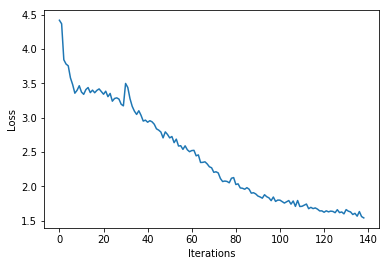

N/A%|#                                              |Time:  0:00:02  Loss: 1.58


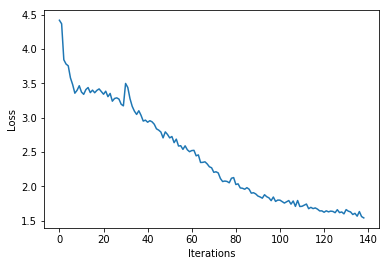

In [0]:
# Training step
EPOCHS = 5 
'''TODO: experiment with different optimizers'''
'''How does changing this affect the network's performance?'''
optimizer = tf.train.AdamOptimizer() # TODO
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

history = []
plotter = util.PeriodicPlotter(sec=1, xlabel='Iterations', ylabel='Loss')
for epoch in range(EPOCHS):
    start = time.time()

    # Initialize the hidden state at the start of every epoch; initially is None
    hidden = model.reset_states()
    
    # Enumerate the dataset for use in training
    custom_msg = util.custom_progress_text("Loss: %(loss)2.2f")
    bar = util.create_progress_bar(custom_msg)
    for inp, target in bar(dataset):
        # Use tf.GradientTape()
        with tf.GradientTape() as tape:
            '''TODO: feed the current input into the model and generate predictions'''
            predictions = model(inp) # TODO
            '''TODO: compute the loss!'''
            loss = compute_loss(target,predictions)
        
        # Now, compute the gradients and try to minimize
        '''TODO: complete the function call for gradient computation'''
        grads = tape.gradient(loss, model.variables) # TODO
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        # Update the progress bar!
        history.append(loss.numpy().mean())
        custom_msg.update_mapping(loss=history[-1])
        plotter.plot(history)
        
    # Update the model with the changed weights!
    model.save_weights(checkpoint_prefix.format(epoch=epoch))



## 2.5 Generate music using the RNN model

Now, we can use our trained RNN model to generate some music! When generating music, we'll have to feed the model some sort of seed to get it started (because it can't predict anything without something to start with!).

Once we have a generated seed, we can then iteratively predict each successive character (remember, we are using the ABC representation for our music) using our trained RNN. More specifically, recall that our RNN outputs a softmax over possible successive caharacters. For inference, we iteratively sample from these distributions, and then use our samples to encode a generated song in the ABC format.

Then, all we have to do is write it to a file and listen!

### Restore the latest checkpoint

To keep this inference step simple, we will use a batch size of 1. Because of how the RNN state is passed from timestep to timestep, the model will only be able to accept a fixed batch size once it is built. 

To run the model with a different `batch_size`, we'll need to rebuild the model and restore the weights from the latest checkpoint, i.e., the weights after the last checkpoint during training:

In [0]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            21248     
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (1, None, 1024)           5251072   
_________________________________________________________________
dense_1 (Dense)              (1, None, 83)             85075     
Total params: 5,357,395
Trainable params: 5,357,395
Non-trainable params: 0
_________________________________________________________________


Notice how now in our `model.summary` the first dimension of the output shape is 1. This is because we have fed in a fixed `batch_size` of 1.

### The prediction procedure

Now, we're ready to write the code to generate text in the ABC music format:

* Initialize a "seed" start string and the RNN state, and set the number of characters we want to generate.

* Use the start string and the RNN state to obtain the probability distribution of the next predicted character.

* Sample from multinomial distribution to calculate the index of the predicted character. This predicted character is then used as the next input to the model.

* At each time step, the updated RNN state returned is fed back into the model, so that it now has more context. After predicting the next character, the updated RNN states are again fed back into the model, which is how it learns sequence dependencies in the data, as it gets more information from the previous predictions.

![LSTM inference](https://raw.githubusercontent.com/aamini/introtodeeplearning_labs/2019/lab1/img/lstm_inference.png)

Complete and experiment with this code block (as well as some of the aspects of network definition and training!), and see how the model performs. How do songs generated after training with a small number of epochs compare to those generated after a longer duration of training?

In [0]:
'''TODO: Use the model to generate ABC format text!'''
# As you may notice, ABC files start with "X" - this may be a good start string
text = generate_text(model,"X")

100%|#########################################################|Time:  0:00:05  


### Play back the generated music!

We can now call a function to convert the ABC format text to an audio file, and then play that back to check out our generated music! Try training longer if the resulting song is not long enough!

In [0]:
util.play_generated_song(text)

Found 2 possible songs in generated texts


In [0]:
print(text)
#Uncomment below  and cahnge to desired name to save and download the model you created
'''model.save('musicGenRNN.h5')
% ls -al
from google.colab import files
files.download('musicGenRNN.h5')'''

XQDO/8
K:C ianl/G,D E3:|!
d>dBA G2BG|AGGF G2:|!
K:|G3G|DFEG ABdB FGAF|E2AF DGDC|!
A2dB ecdB|A3B cAGF|FFA2 BABg|BcBA dBGA|!
dDB^dB ABAF|E3BA B2e2f|!
bfaf agfe a2A2|aga deB|A3 g2f|ga fe|fe fd|ed Bd|!

X:/6
K:c Majide,
A2:2 M:jolin1a2|Heea|gef^c AGEE|d2ed fged|cAFG G2G:|!
cAF|A2d2 BAg|]ABBc eGB|BdB GBG|B,FE A,D:|!
f2 e2|]3
E D2B/|dB|G2 A2|fd d2 A2|B A:|!
A2 Ae|B d2:|!
e2 f2|a2 a^b|df dg|fgg afg|fed afaro
Z: id:dc-reel-1914
M:C/
L:1/8
K:GA a2A|dBA (FGB|def fGA||!3
a3 eba|g3 g2|ddB A2:|!
d|gfg feg|afe dd|c2A B^AB|AFG G:d|!
GFEF FAFD|]!
a3|eaf fdB|d3|G AGE EDG|ABG EG:|!

X:32
N:Gc-1iangifn/v2e
Z: id:dc-reel-3732
M:6/8
L:1/8
K:G Major
B|d2 Regf a2f|geg fdd|efd efd|!ga2 g2ga|!
f2d e2A|G2F G3:|!
g2g eged|f3 gga|f3 a2e|!
g|]2f2 A2o|ag feB|!
E2 D2|cd B4|A/ BF A DD|GF EFA|cA GF|ef ef|d^e de^|4
c1 !
G:|!
A|d3 D3A|dFB GFA|!
ABA FG EG|def eBG|B2 Add|edg edd|!
a2fe g3|g2a a3|A2 AF|D2F DF|G2F GGB|AGF G2:|!

X:123
T:xiinhesg ca|t
Z: did:-sien7
M:/3/8
L:1/8
K:G Mixolyian
idid2 cA|g3 f2|dB GBd|AGE GBG|BGF

"model.save('musicGenRNN.h5')\n% ls -al\nfrom google.colab import files\nfiles.download('musicGenRNN.h5')"

## 2.6 Experiment!

Congrats on making your first sequence model in TensorFlow! It's a pretty big accomplishment, and hopefully you have some sweet tunes to show for it.

If you want to go further, consider how you may improve your model and what seems to be most important in terms of performance. Here are some ideas to get you started:

*  How does the number of training epochs affect the performance?
*  What if you alter or augment the dataset? 
*  Does the choice of start string significantly affect the result? 

Have fun and happy listening!


![Let's Dance!](http://33.media.tumblr.com/3d223954ad0a77f4e98a7b87136aa395/tumblr_nlct5lFVbF1qhu7oio1_500.gif)



